## import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Datasets

In [2]:
from load_data import load_data

In [3]:
train_x,train_y,test_x,test_y=load_data(7000,2000)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting datasets/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting datasets/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting datasets/t10k-images-idx3-ubyte.gz
Extracting datasets/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
The shape of train_x is (784, 7000)
The shape of train_y is (10, 7000)
The shape of test_x is (784, 2000)
The shape of test_y is (10, 2000)


## 2 - L-layers initialize parameters

In [4]:
def init_paras(X,Y,dims):
    np.random.seed(0)
    paras={}
    L=len(dims)
    
    paras["W1"]=np.random.randn(dims[0],X.shape[0])*0.01
    paras["b1"]=np.zeros((dims[0],1))
    for l in range(1,L):
        paras["W"+str(l+1)]=np.random.randn(dims[l],dims[l-1])*0.01
        paras["b"+str(l+1)]=np.zeros((dims[l],1))
    paras["W"+str(L+1)]=np.random.randn(Y.shape[0],dims[L-1])*0.01
    paras["b"+str(L+1)]=np.zeros((Y.shape[0],1))
    return paras

In [5]:
paras=init_paras(train_x,train_y,[1,2,3,4])
for l in range(len(paras)//2):
    print("W"+str(l+1)+" = "+str(paras["W"+str(l+1)].shape))
    print("b"+str(l+1)+" = "+str(paras["b"+str(l+1)].shape))

W1 = (1, 784)
b1 = (1, 1)
W2 = (2, 1)
b2 = (2, 1)
W3 = (3, 2)
b3 = (3, 1)
W4 = (4, 3)
b4 = (4, 1)
W5 = (10, 4)
b5 = (10, 1)


## 3 - L-layers forward propagate

In [6]:
def relu(cache):
    A_prev,W,b,Z=cache
    return np.maximum(0,Z)
def linear_forward(A_prev,W,b):
    Z=np.dot(W,A_prev)+b
    cache=(A_prev,W,b,Z)
    return cache
def softmax(cache):
    A_prev,W,b,Z=cache
    weight=np.exp(Z)
    return np.divide(weight,weight.sum(0))

In [7]:
def forward_propagate(X,paras):
    L=len(paras)//2
    caches=[]
    A=X
    for l in range(1,L):
        cache=linear_forward(A,paras["W"+str(l)],paras["b"+str(l)])
        A=relu(cache)
        caches.append(cache)
    cache=linear_forward(A,paras["W"+str(L)],paras["b"+str(L)])
    AL=softmax(cache)
    caches.append(cache)
    return AL,caches

## 4 - Compute cost

In [8]:
def compute_cost(AL,Y):
    cost=np.sum(np.multiply(-np.log(AL),Y))/Y.shape[1]
    return cost

## 5 - Backward propagate

In [9]:
def linear_back(dA,cache,lambd):
    A_prev,W,b,Z=cache
    m=dA.shape[1]
    dZ=relu_back(dA,Z)
    dW=np.dot(dZ,A_prev.T)/m+lambd*W/m
    dA_prev=np.dot(W.T,dZ) 
    db=np.sum(dZ,axis = 1, keepdims = True)/m
    return dW,dA_prev,db
def relu_back(dA,Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [10]:
def backward_propagate(X,Y,caches,AL,lambd):
    grads={}
    L=len(caches)
    m=Y.shape[1]
    
    A_prev,W,b,Z=caches[L-1]
    dZL=AL-Y
    grads["dW"+str(L)]=np.dot(dZL,A_prev.T)/m+lambd*W/m
    grads["db"+str(L)]=np.sum(dZL,axis = 1, keepdims = True)/m
    grads["dA"+str(L-1)]=np.dot(W.T,dZL)
    
    for l in reversed(range(L-1)):
        grads["dW"+str(l+1)],grads["dA"+str(l)],grads["db"+str(l+1)]=linear_back(grads["dA"+str(l+1)],caches[l],lambd)
    return grads

### 6 - Updata paras

In [11]:
def updata_paras(paras,grads,learning_rate=0.6):
    L=len(paras)//2
    for l in range(1,L+1):
        paras["W"+str(l)]-=learning_rate*grads["dW"+str(l)]
        paras["b"+str(l)]-=learning_rate*grads["db"+str(l)]
    return paras

## 建立模型

In [12]:
def model(X, Y, layers_dims, lambd,learning_rate = 0.3, num_iterations = 3000, print_cost=True):
    costs = []
    paras=init_paras(train_x,train_y,layers_dims)
    for i in range(0, num_iterations):
        AL,caches=forward_propagate(train_x,paras)
        cost=compute_cost(AL,train_y)
        grads=backward_propagate(train_x,train_y,caches,AL,lambd)
        paras=updata_paras(paras,grads,learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return paras

In [13]:
def predict(X,Y,paras):
    AL,_=forward_propagate(X,paras)
    m = X.shape[1]

    p=AL.argmax(0)
    y=Y.argmax(0)
    
    num=0
    for i in range(len(p)):
        if p[i]==y[i]:
            num+=1
    print("Accuracy: "  + str(num*100/m)+"%")

In [14]:
def remodel(paras,X, Y, layers_dims, lambd,learning_rate = 0.3, num_iterations = 3000, print_cost=True):
    costs = []
    for i in range(0, num_iterations):
        AL,caches=forward_propagate(train_x,paras)
        cost=compute_cost(AL,train_y)
        grads=backward_propagate(train_x,train_y,caches,AL,lambd)
        paras=updata_paras(paras,grads,learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return paras

Cost after iteration 0: 2.302584
Cost after iteration 100: 2.300320
Cost after iteration 200: 2.300239
Cost after iteration 300: 2.299101
Cost after iteration 400: 1.696808
Cost after iteration 500: 1.023755
Cost after iteration 600: 0.718111
Cost after iteration 700: 0.636570
Cost after iteration 800: 0.354317
Cost after iteration 900: 0.278639
Cost after iteration 1000: 0.278662
Cost after iteration 1100: 0.215181
Cost after iteration 1200: 0.206121
Cost after iteration 1300: 0.162178
Cost after iteration 1400: 0.150060


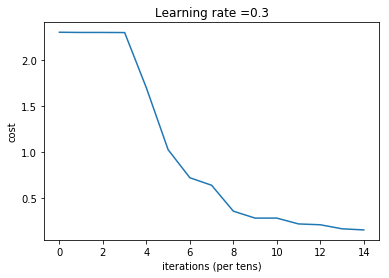

In [15]:
layers_dims=[10,9]
paras=model(train_x, train_y, layers_dims,lambd=2,learning_rate = 0.3,num_iterations = 1500)

### 继续训练

Cost after iteration 0: 0.133552
Cost after iteration 100: 0.118853
Cost after iteration 200: 0.113735
Cost after iteration 300: 0.108972
Cost after iteration 400: 0.104513


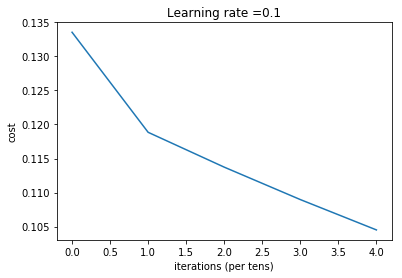

In [18]:
paras=remodel(paras,train_x, train_y, layers_dims,lambd=2,learning_rate = 0.1,num_iterations = 500)

In [21]:
pred_train = predict(train_x, train_y, paras)

Accuracy: 97.31428571428572%


In [22]:
pred_test=predict(test_x,test_y,paras)

Accuracy: 88.2%
